**Importing the necessary libraries**

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Input, Flatten
from tensorflow.keras.activations import relu

**Mounting the Google Drive and Loading the Data**

In [99]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
df_train = pd.read_csv("/content/drive/MyDrive/Fashion_MNIST/fashion-mnist_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Fashion_MNIST/fashion-mnist_test.csv")

In [101]:
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [102]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


**Preparing the Dataset**

In [103]:
df_train_output = df_train.pop("label") # taking out output from the dataframe
df_test_output = df_test.pop("label")

In [104]:
df_train_input = df_train.copy() # the copying the input dataframe
df_test_input = df_test.copy()

In [105]:
def preprocess_data(df_input, df_output, width, height):
  """
  Inputs:
  1. df_input = input pandas dataframe
  2. df_output = output pandas dataframe (must contain only one column)
  3. width - size of the width you want the vector to be transformed (int)
  4. height - size of the height you want the vector to become transformed (int)

  Returns:
  1. np_i - input array without normalising (numpy)
  2. np_i_scaled - normalized input array (numpy)
  3. np_o - output array without OneHotEncoding (numpy)
  4. np_o_ohe - output array with OneHotEncoding (numpy)
  5. ohe - the fitted OneHotEncoder 
  """
  df_i = df_input.copy()
  df_o = df_output.copy()

  np_i = df_i.to_numpy("float32")  # converting to numpy format
  np_i = np.reshape(np_i, (-1, width, height, 1))  # reshaping the vector into 2D array 
  np_i_scaled = (np_i - 127.5) / 127.5  # normalizing the input features between 0 and 1
  
  np_o = df_o.to_numpy("float32")
  np_o = np.reshape(np_o, (-1,1))  # if previous shape was (None,) it will be changed to (None, 1)
  ohe = OneHotEncoder()  # using one-hot encoder
  np_o_ohe = ohe.fit_transform(np_o).toarray()

  return np_i, np_i_scaled, np_o, np_o_ohe, ohe

In [106]:
np_train_input, np_train_input_scaled, np_train_output, np_train_output_ohe, ohe = preprocess_data(df_train_input, df_train_output, 28, 28)
np_test_input, X_test, np_test_output, Y_test, _ = preprocess_data(df_test_input, df_test_output, 28, 28)

In [107]:
X_train, X_val, Y_train, Y_val = train_test_split(np_train_input_scaled, np_train_output_ohe, test_size=0.2, shuffle=True, random_state=10)  # Creating training and validation data 

**Viewing the Dataset**

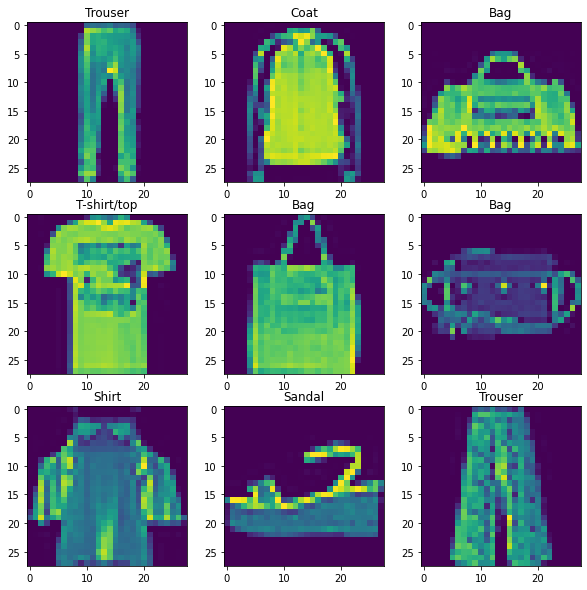

In [108]:
view_array = np.random.randint(0, len(X_train), size=9)
fig,ax = plt.subplots(3, 3, figsize = (10,10))
ax = ax.ravel()
for i in range(0,9):
    ax[i].imshow(np.squeeze(X_train[view_array[i]])) # squeezing from (28,28,1) to (28,28) for imshow
    title = label_dict[ohe.inverse_transform(Y_train)[view_array[i]][0]]  # reverse transforming onehot array and accessing the label's name
    # in label_dict for the given number. Examine the line separately if you are confused. 
    ax[i].title.set_text(title)

**Defining and Compiling the CNN Model**

In [109]:
def define_model():
  """
  Batch Normalisation is used to train the NN faster and allows us to use higher learning rates.
  Use it after the Conv2D or Dense layer. Set use_bias = False since bias is unnecessary when using Batch Normalisation.
  Use the activations after the Batch Normalisation layer. Not before.
  Use 'He' initialiser for ReLU and 'Glorot' for tanh
  Use Categorical Crossentropy when Y_train is OneHot encoded. Otherwise use Sparse Categorical Crossentropy
  """
  inp = Input(shape=(28, 28, 1),name="Input_Layer")

  x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer="he_uniform", use_bias=False, name="Conv2D_1")(inp)
  x = BatchNormalization()(x)
  x = relu(x)
  x = MaxPool2D(pool_size=(2,2), name="MaxPool_1")(x)

  x = Conv2D(64, (3,3), (1,1), "valid", kernel_initializer="he_uniform", use_bias=False, name="Conv2D_2")(x)
  x = BatchNormalization()(x)
  x = relu(x)
  x = MaxPool2D(pool_size=(2,2), name="MaxPool_2")(x)

  x = Flatten(name="Flatten_Layer")(x)

  x = Dense(512, kernel_initializer="he_uniform", use_bias=False, name="Dense_1")(x)
  x = BatchNormalization()(x)
  x = relu(x)

  x = Dense(128, kernel_initializer="he_uniform", use_bias=False, name="Dense_2")(x)
  x = BatchNormalization()(x)
  x = relu(x)

  x = Dense(10, activation="softmax", name="Output_Layer")(x)

  model = Model(inputs=inp, outputs=x)
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

  return model


In [114]:
model = define_model()
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 26, 26, 32)        288       
_________________________________________________________________
batch_normalization_35 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
tf.nn.relu_16 (TFOpLambda)   (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 11, 11, 64)        18432     
_________________________________________________________________
batch_normalization_36 (Batc (None, 11, 11, 64)        256

**Run the Model**

In [115]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
history = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_data=(X_val, Y_val))

Epoch 1/40
375/375 [==============================] - 62s 162ms/step - loss: 0.5369 - accuracy: 0.8060 - val_loss: 0.3719 - val_accuracy: 0.8663
Epoch 2/40
375/375 [==============================] - 60s 160ms/step - loss: 0.2813 - accuracy: 0.8954 - val_loss: 0.2859 - val_accuracy: 0.9004
Epoch 3/40
375/375 [==============================] - 61s 162ms/step - loss: 0.2382 - accuracy: 0.9124 - val_loss: 0.2435 - val_accuracy: 0.9125
Epoch 4/40
375/375 [==============================] - 61s 163ms/step - loss: 0.2006 - accuracy: 0.9254 - val_loss: 0.3078 - val_accuracy: 0.8873
Epoch 5/40
375/375 [==============================] - 61s 162ms/step - loss: 0.1719 - accuracy: 0.9355 - val_loss: 0.2876 - val_accuracy: 0.8995
Epoch 6/40
375/375 [==============================] - 60s 161ms/step - loss: 0.1458 - accuracy: 0.9461 - val_loss: 0.2775 - val_accuracy: 0.9087
Epoch 7/40
375/375 [==============================] - 60s 160ms/step - loss: 0.1285 - accuracy: 0.9535 - val_loss: 0.3117 - val_ac

In [137]:
_, acc_train = model.evaluate(X_train, Y_train)
_, acc_val = model.evaluate(X_val, Y_val)
_, acc_test = model.evaluate(X_test, Y_test)
print(" Test Accuracy: {} \n Val Accuracy: {} \n Test Accuracy: {}".format(acc_train, acc_val, acc_test))

313/313 [==============================] - 3s 10ms/step - loss: 0.5340 - accuracy: 0.9185
 Test Accuracy: 0.9954166412353516 
 Val Accuracy: 0.9122499823570251 
 Test Accuracy: 0.9185000061988831


**Viewing the Test Data with Predicted Label**

In [135]:
predicted_label = np.squeeze(ohe.inverse_transform(model.predict(X_test)))
true_label = np.squeeze(np_test_output)

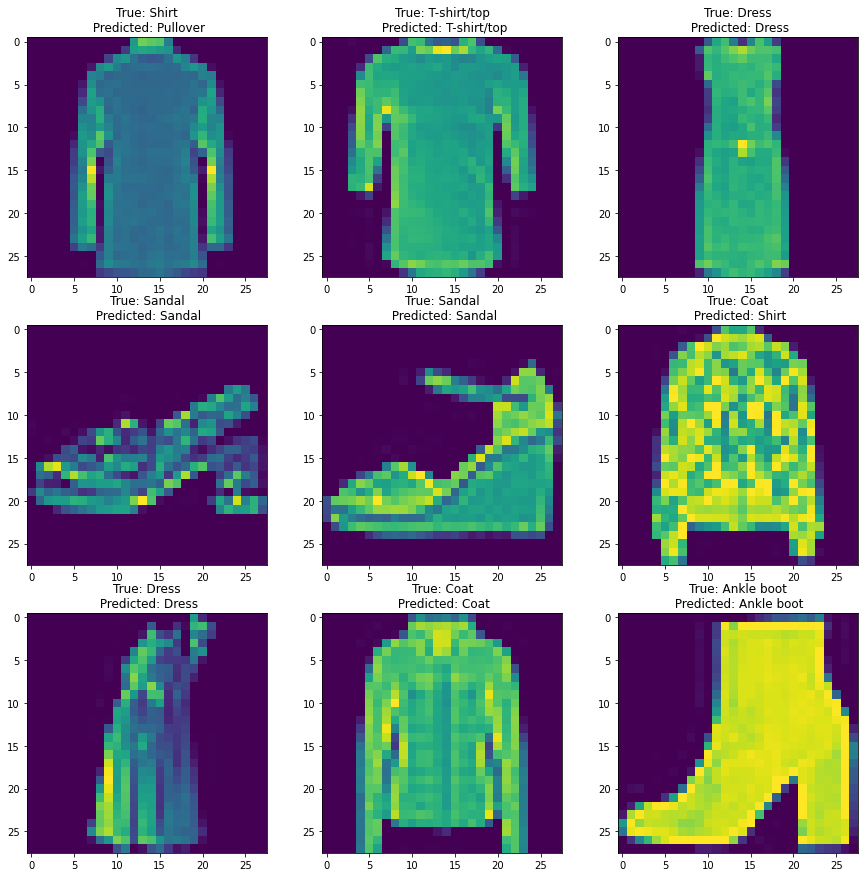

In [139]:
view_array = np.random.randint(0, len(X_test), size=9)
fig,ax = plt.subplots(3, 3, figsize = (15,15))
ax = ax.ravel()
for i in range(0,9):
    ax[i].imshow(np.squeeze(X_test[view_array[i]])) # squeezing from (28,28,1) to (28,28) for imshow
    title = "True: " + label_dict[true_label[view_array[i]]] + "\n Predicted: " + label_dict[predicted_label[view_array[i]]] # reverse transforming onehot array and accessing the label's name
    # in label_dict for the given number. Examine the line separately if you are confused. 
    ax[i].title.set_text(title)